In [76]:
import json
import pandas as pd
from pprint import pprint
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
import string
import re
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import k_means
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy import hstack
from numpy import atleast_2d, where


There are two different ways of downloading the datasets
'casualties.txt' and 'casualties_data.txt'
casualties_data has less extraneous data than casualties, but is missing latitude/longitude values, so I extract those values from 'casualities'

The datasets are found in this folder, and at:
https://safetydata.fra.dot.gov/OfficeofSafety/publicsite/Query/casrpt.aspx

In [2]:
df = pd.read_csv('casualties.txt',sep=',')
df.INCDTNO = df.INCDTNO.apply(lambda d: d.strip())

In [ ]:
df.L

For values with missing latitutde/ longitude, I downloaded a dataset with long/lat values by city from:

https://www.gaslampmedia.com/download-zip-code-latitude-longitude-city-state-county-csv/

The entries in the train dataset have county/state information.

In [3]:
cities = pd.read_csv('zip_codes_states.csv')
cities = cities.drop(['zip_code'],1)
cities = cities[cities.state != 'PR']
cities = cities.dropna(axis=0)

In [7]:
#first approach
cas = pd.read_csv('casualty_data.txt',sep='\t')
cas = cas.fillna(0)
acceptable_characters = string.letters + string.digits + "-_*."
filter(lambda c: c in acceptable_characters, cas.Type)
cas.Type = cas.Type.apply(lambda row: row[:len(row)-1])

In [8]:
cas = cas[cas.St.isnull() != True] #DROP HAWAII, #DROP ALASKA
ak = cas[cas.St=='AK']
cas = cas[cas.St != 'AK' ]
cas = cas.drop(cas.columns[[0]],axis=1)
for idx, row in cas.iterrows():
    if row.Month=='January':
        cas.ix[idx, 'Month'] = 1
    elif row.Month=='February':
        cas.ix[idx, 'Month'] = 2
    elif row.Month=='March':
        cas.ix[idx, 'Month'] = 3
    elif row.Month=='April':
        cas.ix[idx, 'Month'] = 4
    elif row.Month=='May':
        cas.ix[idx, 'Month'] = 5
    elif row.Month=='June':
        cas.ix[idx, 'Month'] = 6
    elif row.Month=='July':
        cas.ix[idx, 'Month'] = 7
    elif row.Month=='August':
        cas.ix[idx, 'Month'] = 8
    elif row.Month=='September':
        cas.ix[idx, 'Month'] = 9
    elif row.Month=='October':
        cas.ix[idx, 'Month'] = 10
    elif row.Month=='November':
        cas.ix[idx, 'Month'] = 11
    elif row.Month=='December':
        cas.ix[idx, 'Month'] = 12

In [14]:
add_geo(cas,df)

ValueError: Incompatible indexer with Series

In [26]:
cas['Lat'] = 0
cas['Long'] = 0
#cas=cas[type(cas.County)==type('str')]
for idx, row in cas.iterrows():
    if type(row.County) != type('str'):
        cas.ix[idx,'County'] = ""
    if type(row.St) != type('str'):
        cas.ix[idx,'St'] = ""

In [27]:
for idx, row in cas[cas.Lat==0].iterrows():
    co = row.County.title().strip()
    st = row.St.strip()
    if (co=="Washington," and st=='DC'):
        co = 'District Of Columbia'
    co_series = cities[cities.county==co]
    matches = co_series[co_series.state==st]
    cas.ix[idx,'Long'] = matches.longitude.mean()
    cas.ix[idx,'Lat'] = matches.latitude.mean()
cas = cas[cas.Long.isnull() != True]

In [29]:
cas.Condition = cas.Condition.apply(lambda row: "Electric Shock" if "Electric" in row else row)      
cas.Condition = cas.Condition.apply(lambda row: "Heat" if "Heat" in row else row)           
cas.Condition = cas.Condition.apply(lambda row: "Injury" if "injury" in row else row)      
cas.Condition = cas.Condition.apply(lambda row: "Sprain" if "Sprain" in row else row)      
cas.Condition = cas.Condition.apply(lambda row: "Cut/Abrasion" if "Cut/abrasion" in row else row)      
cas.Condition = cas.Condition.apply(lambda row: "Fracture" if "Fracture" in row else row)      
cas.Condition = cas.Condition.apply(lambda row: "Bruise/Contusion" if "Bruise/Contusion" in row else row)      
cas.Condition = cas.Condition.apply(lambda row: "Concussion" if "Concussion" in row else row)      
        
cas.Event = cas.Event.apply(lambda row:"Caught" if "Caught" in row else row)
cas.Event = cas.Event.apply(lambda row:"Sudden/unexpected movement" if "Sudden" in row else row)
cas.Event = cas.Event.apply(lambda row:"Animal/insect bite/sting" if "Bitten" in row else row)
cas.Event = cas.Event.apply(lambda row:"Electrical Shock" if "Electric" in row else row)
cas.Event = cas.Event.apply(lambda row:"Slipped" if "Slipped" in row else row)
cas.Event = cas.Event.apply(lambda row:"Struck" if "Struck" in row else row)
cas.Event = cas.Event.apply(lambda row:"Assault" if "Assault" in row or "Stab" in row
                            or "Shot" in row else row)

In [13]:
def add_geo(subframe, largerframe):
    for idx, row in subframe.iterrows():
        i = row.Incident
        subframe.ix[idx,'Long'] = largerframe.LONGITUD[largerframe.INCDTNO==i]
        subframe.ix[idx,'Lat'] = largerframe.LATITUDE[largerframe.INCDTNO==i]
        print i
        #        for jdx, rowj in largerframe.iterrows():
#            if i==rowj.INCDTNO:
#                subframe.ix[idx,'Long'] = rowj.LONGITUD
#                subframe.ix[idx,'Lat'] = rowj.LATITUDE
        break
    return subframe

In [31]:
cas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8865 entries, 0 to 9214
Data columns (total 14 columns):
RR           8865 non-null object
Month        8865 non-null object
Day          8865 non-null int64
TA           8865 non-null int64
Incident     8865 non-null object
Type         8865 non-null object
Job          8865 non-null object
Condition    8865 non-null object
Event        8865 non-null object
St           8865 non-null object
County       8865 non-null object
Age          8865 non-null float64
Long         8865 non-null float64
Lat          8865 non-null float64
dtypes: float64(3), int64(2), object(9)
memory usage: 1.0+ MB


Stratify the table by the different variables, conditions, victims, and events/causes

In [32]:
cols = cas.Condition.value_counts()[cas.Condition.value_counts()>2].index
conditions = pd.DataFrame(index=cas.RR.unique(), columns= cols)
for rail, rail_data in cas.groupby("RR"):
    conditions.ix[rail,cols] = rail_data.Condition.value_counts()[cols]
conditions=conditions.fillna(0)

victims = pd.DataFrame(index=cas.RR.unique(), columns= cas.Type.unique())
for rail, rail_data in cas.groupby("RR"):
    victims.ix[rail,rail_data.Type.unique()] = rail_data.Type.value_counts()
victims=victims.fillna(0)
#victims.head()

#electric shock is a condition, electrical is a cause/event
events = pd.DataFrame(index=cas.RR.unique(), columns= cas.Event.unique())
for rail, rail_data in cas.groupby("RR"):
    events.ix[rail,rail_data.Event.unique()] = rail_data.Event.value_counts()
    events.ix[rail,'Count'] = rail_data.RR.count()
events = events.fillna(0)

for rail, rail_data in cas.groupby('RR'):
    events.ix[rail,'Condition'] = rail_data.Condition.value_counts().index[0]
    conditions.ix[rail,'Event'] = rail_data.Event.value_counts().index[0]
conditions.Event = conditions.Event.apply(lambda row: row[0:10])

events_top = events.sort(columns='Count',ascending=False)[0:40]
events = events.drop(['Count'],axis=1)
events_top = events_top.drop(['Count'],axis=1)

trains = pd.concat([victims, events],axis=1)
trains_top = trains.ix[events_top.index]

Here we start exploring the values:

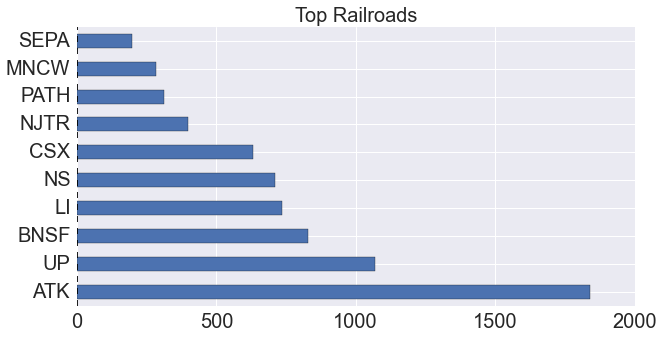

In [33]:
#cons = tdf.Condition.value_counts().ix[0:10]
t = cas.RR.value_counts().ix[0:10]
t.plot(kind='barh',figsize=(10, 5), fontsize=20).set_title('Top Railroads',fontsize=20);

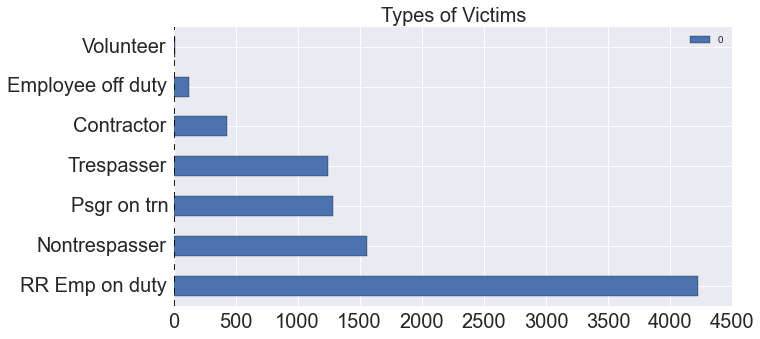

In [51]:
types = pd.DataFrame(cas.Type.value_counts())
types.plot(kind='barh',figsize=(10, 5),fontsize=20).set_title('Types of Victims',fontsize=20);

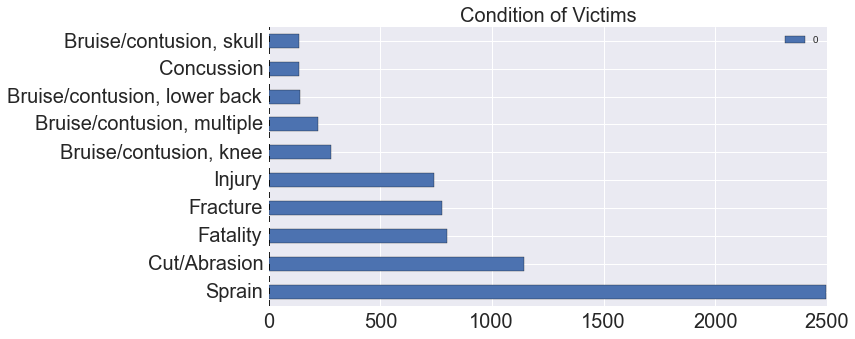

In [52]:
cons = pd.DataFrame(cas.Condition.value_counts().ix[0:10])
cons.plot(kind='barh',figsize=(10, 5), fontsize=20).set_title('Condition of Victims',fontsize=20);

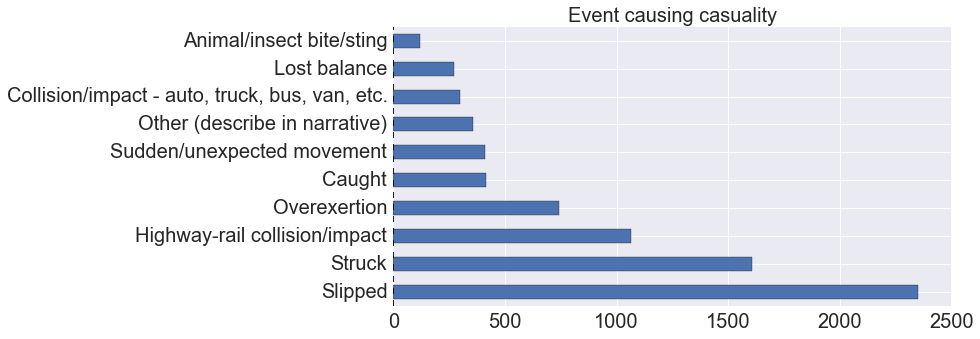

In [58]:
events = cas.Event.value_counts().ix[0:10]
events.plot(kind='barh',figsize=(10, 5),fontsize=20).set_title('Event causing casuality',fontsize=20);


In [60]:
cols = cas.Condition.value_counts()[cas.Condition.value_counts()>2].index
conditions = pd.DataFrame(index=cas.RR.unique(), columns= cols)
for rail, rail_data in cas.groupby("RR"):
    conditions.ix[rail,cols] = rail_data.Condition.value_counts()[cols]
conditions=conditions.fillna(0)

victims = pd.DataFrame(index=cas.RR.unique(), columns= cas.Type.unique())
for rail, rail_data in cas.groupby("RR"):
    victims.ix[rail,rail_data.Type.unique()] = rail_data.Type.value_counts()
victims=victims.fillna(0)
#victims.head()

#electric shock is a condition, electrical is a cause/event
events = pd.DataFrame(index=cas.RR.unique(), columns= cas.Event.unique())
for rail, rail_data in cas.groupby("RR"):
    events.ix[rail,rail_data.Event.unique()] = rail_data.Event.value_counts()
    events.ix[rail,'Count'] = rail_data.RR.count()
events = events.fillna(0)

for rail, rail_data in cas.groupby('RR'):
    events.ix[rail,'Condition'] = rail_data.Condition.value_counts().index[0]
    conditions.ix[rail,'Event'] = rail_data.Event.value_counts().index[0]
conditions.Event = conditions.Event.apply(lambda row: row[0:10])

events_top = events.sort(columns='Count',ascending=False)[0:40]
events = events.drop(['Count'],axis=1)
events_top = events_top.drop(['Count'],axis=1)

trains = pd.concat([victims, events],axis=1)
trains_top = trains.ix[events_top.index]

train vs condition of victim
Train vs Type of Victim
Trains vs event that caused the accident

In [54]:
cas = cas.fillna(0)
X= cas.Long.values
Y= cas.Lat.values
X_scaler = StandardScaler(with_std=True)
scaled_X = X_scaler.fit_transform(X)
Y_scaler = StandardScaler(with_std=True)
scaled_Y = Y_scaler.fit_transform(Y)
cas['SCALED_LONG'] = scaled_X
cas['SCALED_LAT'] = scaled_Y

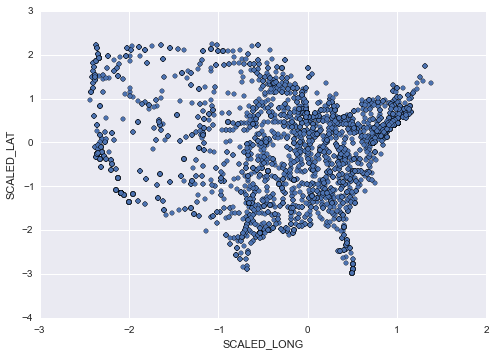

In [55]:
cas.plot(kind='scatter',x='SCALED_LONG',y='SCALED_LAT')

In [42]:
def evaluate_clustering(X, max_k):
    inertia = []
    inertia.append(0)
    for k in range(1, max_k + 1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=5)
        kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
    return inertia

In [43]:
data = hstack((atleast_2d(scaled_X).T, atleast_2d(scaled_Y).T))
inertia_k = evaluate_clustering(data, 15)

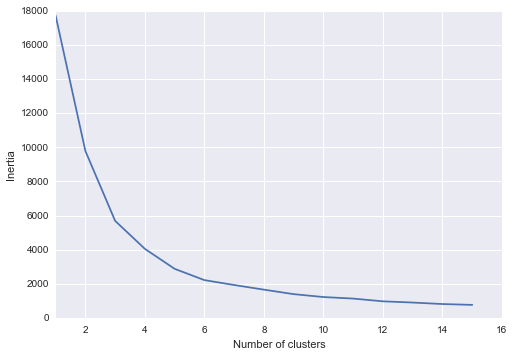

In [44]:
ax = plt.subplot(111)
ax.plot(inertia_k)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
ax.set_xlim(1, len(inertia_k))
plt.show()

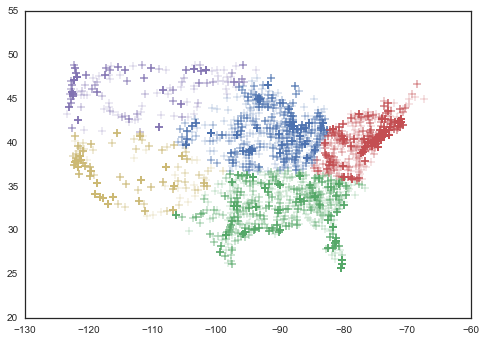

In [45]:
kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(data)
m = pd.DataFrame()
with sns.axes_style("white"):
    ax = plt.subplot(111)
    # Define a color palette
    cmap = sns.color_palette(n_colors=6)
    cmap.extend(sns.hls_palette(n_colors=6, h=0.7, l=0.4, s=0.8))
    # Iterate over the different clustering labels, find the points
    # that belong to that cluster and plot them with the same color
    for i, label in enumerate(set(labels)):
        point_indices = where(labels == label)[0]
        point_indices = point_indices.tolist()
        ax.scatter(X[point_indices], Y[point_indices], s=70, 
                    alpha=1, c=cmap[i], marker='+')
        a = pd.DataFrame([X[point_indices], Y[point_indices]])
        a = a.T
        a['Label'] = i
        m = pd.concat([m,a],axis=0)
m.to_csv('map1.txt')



In [62]:
e = events.drop(['Condition'],axis=1)
e_data = e.values.astype(int)
c = conditions.drop(['Event'],axis=1)
c_data = c.values.astype(int)

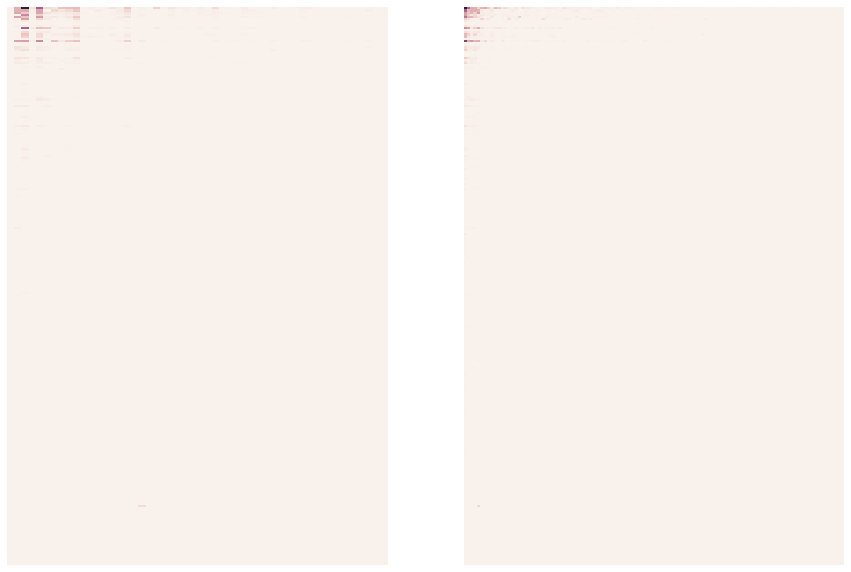

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,10))
sns.heatmap(e_data, xticklabels=False, yticklabels=False, linewidths=0, ax=ax1,  cbar=False)
sns.heatmap(c_data, xticklabels=False, yticklabels=False, linewidths=0, ax=ax2,  cbar=False)

(257L, 52L)


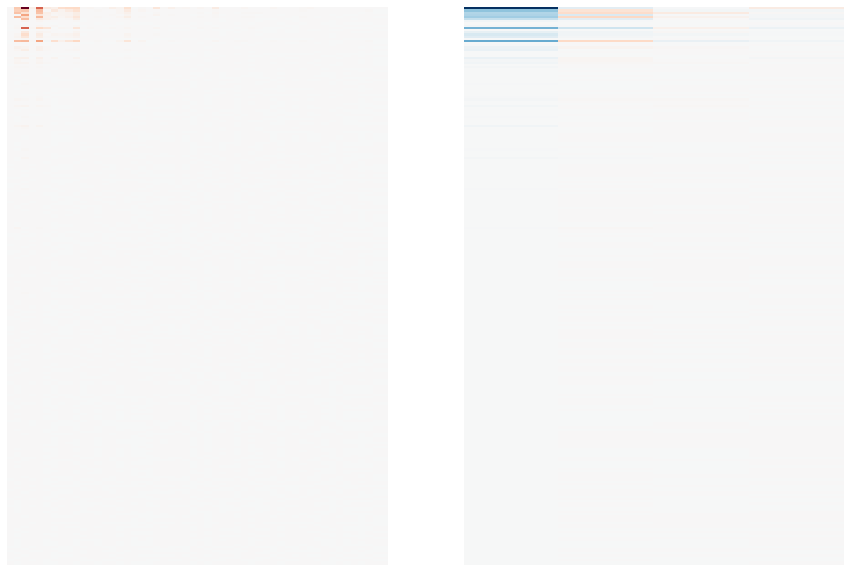

In [66]:
k=4
U, s, V = np.linalg.svd(e_data)
Uk = U[:,0:k]
Vk = V[0:k,:]
Sk = np.diag(s[0:k])
newX = np.dot(np.dot(Uk,Sk),Vk)
print newX.shape
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,10))

sns.heatmap(newX, xticklabels=False, yticklabels=False, linewidths=0, ax=ax1,  cbar=False)
sns.heatmap(np.dot(Uk,Sk), xticklabels=False, yticklabels=False, linewidths=0, ax=ax2, cbar=False)

First, I try to establish a link between time and the casualties that occur:

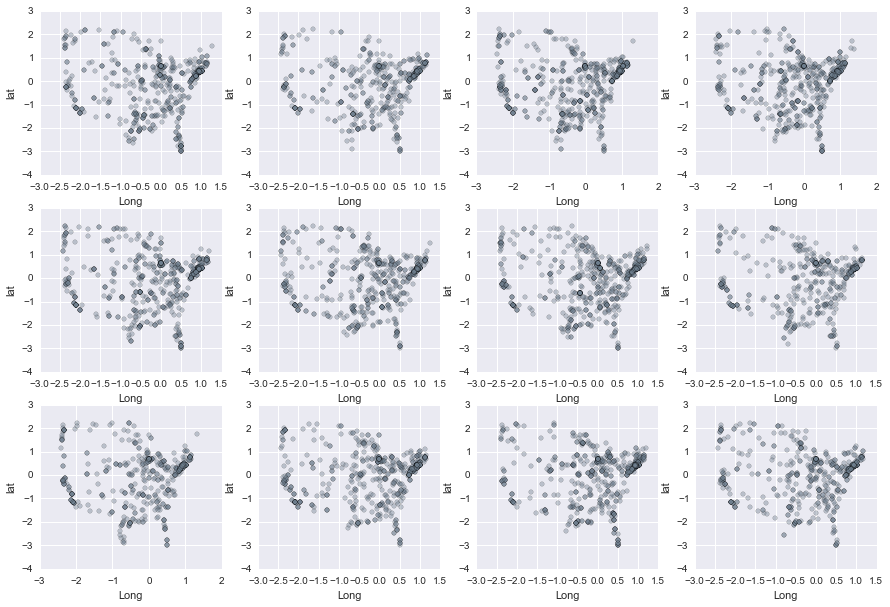

In [67]:
fig, axes = plt.subplots(3,4,figsize=(15,10))

for idx in range(1,13):
    i = idx // 4
    j = idx % 4
    c = cas[cas.Month==idx]
#    print idx, c.RR.count()
    x = c.SCALED_LONG
    y = c.SCALED_LAT
    axes[i-1][j].scatter(x,y, c="slategray", alpha=0.4, linewidths=0.3)
    #plt.scatter(subX_test, y_test)
    axes[i-1][j].set_xlabel('Long')
    axes[i-1][j].set_ylabel('lat');     

The graphs don't show any radical differences geographically, i explore other variables

The important variables are the cause/event of the accident:
1) struck by something
2) slip
3) highway-railroad crash

The victim's condition:
1) fatal
2) non-fatal sprain

Who the victim was:
1)employee
2) passenger

When the casuality occured

In [68]:
cas['STRUCK'] = cas.Event.apply(lambda row: 1 if row == "Struck" else 0)
cas['SLIP'] = cas.Event.apply(lambda row: 1 if row == "Slipped" else 0)
cas['HIGHWAY'] = cas.Event.apply(lambda row: 1 if row == "Highway-rail collision/impact" else 0)
cas['FATAL'] = cas.Condition.apply(lambda row: 1 if "Fatal" in row else 0)
cas['SPRAIN'] = cas.Condition.apply(lambda row: 1 if "Sprain" in row else 0)
cas['EMPLOYEE'] = cas.Type.apply(lambda row: 1 if "Emp" in row else 0)
cas['PASSENGER'] = cas.Type.apply(lambda row: 1 if "Psgr" in row else 0)
cas['SCALED_MONTH'] = MinMaxScaler(copy=True).fit_transform(cas.Month *1.)

In [69]:
factors=['FATAL','EMPLOYEE','SCALED_MONTH']
variables = ['FATAL','EMPLOYEE','SCALED_MONTH']
for i in ['SCALED_LONG','SCALED_LAT','Long','Lat']:
    variables.append(i)
dataset = cas[variables]

In [70]:
inertia_k = evaluate_clustering(dataset[factors], 10)

(1, 11)

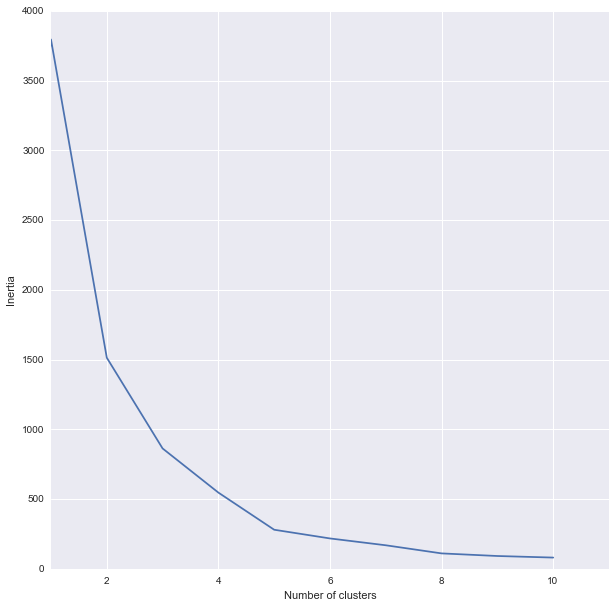

In [71]:
plt.rcParams['figure.figsize'] = (10,10)
ax = plt.subplot(111)
ax.plot(inertia_k)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
ax.set_xlim(1, len(inertia_k))


In [77]:
n_clusters = 5
centroids, labels, inertia = k_means(dataset[factors],
                                    n_clusters =n_clusters,
                                    random_state = 150)
centroids = pd.DataFrame(centroids,columns=(factors))

print centroids

          FATAL      EMPLOYEE  SCALED_MONTH
0  8.924587e-04  1.000000e+00      0.216462
1 -1.373901e-15 -1.620926e-14      0.758805
2 -1.415534e-15 -1.670886e-14      0.224023
3  1.425856e-03  1.000000e+00      0.756568
4  1.000000e+00  6.321113e-03      0.526491


In these graphs I try to explore the result of time, but there doesn't seem to be much a relationship. Hypothesis 3 is not proved here.

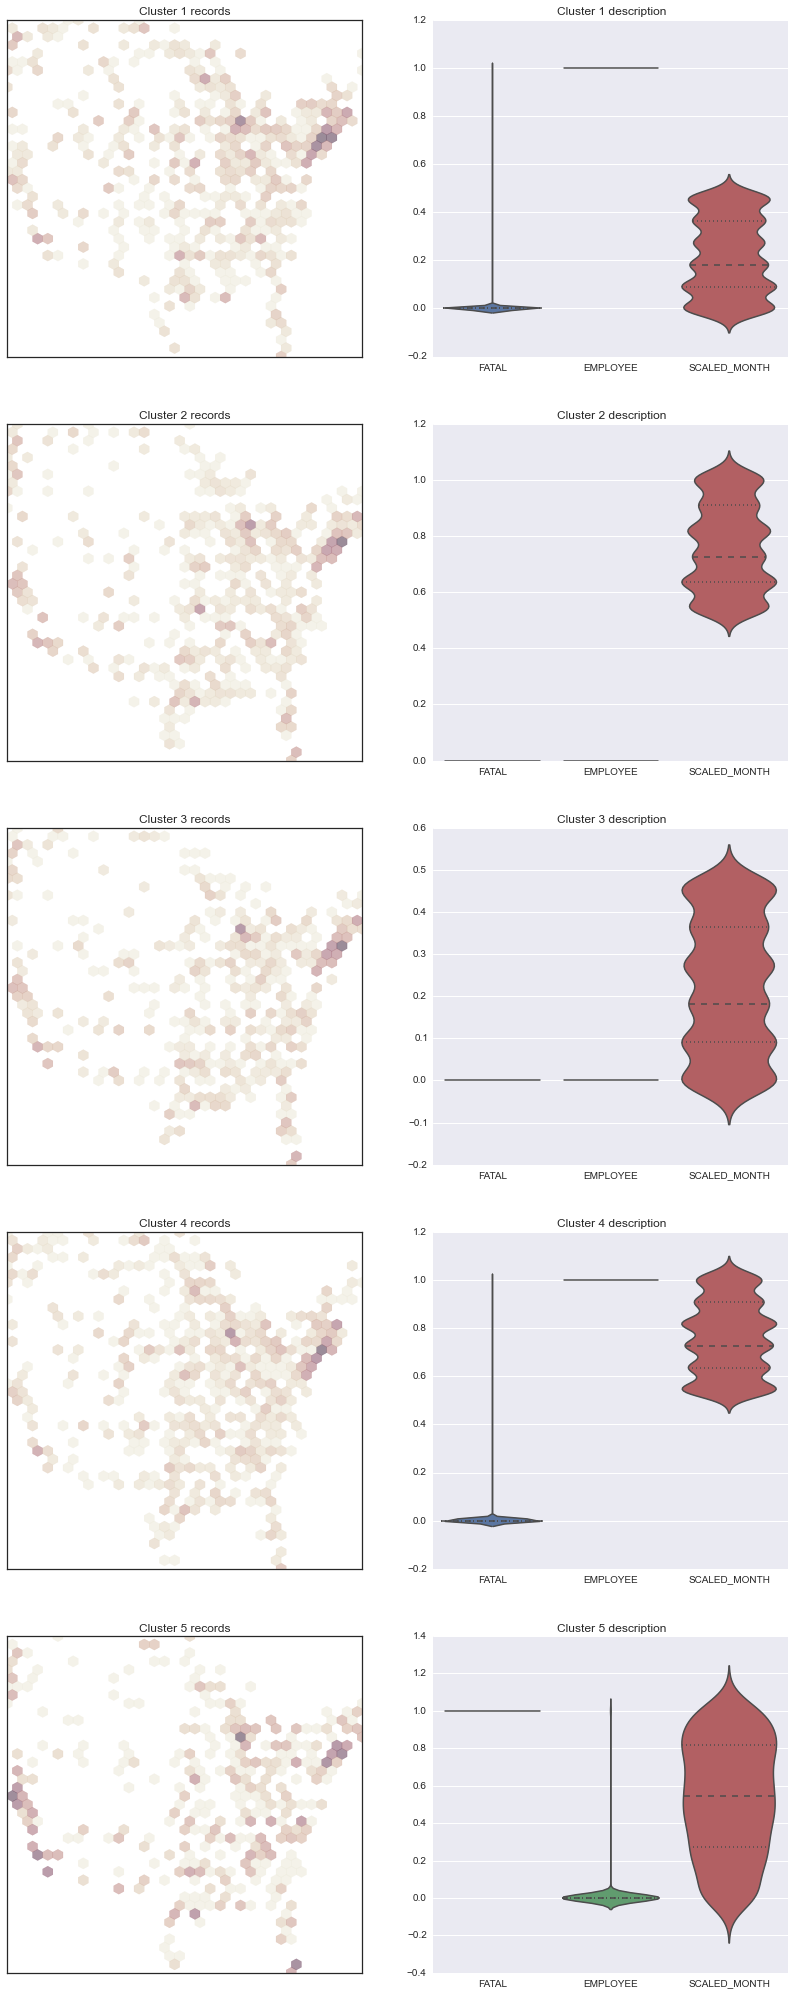

In [78]:
cmap = sns.cubehelix_palette(start=0.3, light=0.9, as_cmap=True)
titles=factors
plt.rcParams['figure.figsize'] = (14,7 * n_clusters)

for i, label in enumerate(set(labels)):
    point_indices = where(labels == label)[0]
    point_indices = point_indices.tolist()
    cluster = dataset.iloc[point_indices]
    with sns.axes_style("white"):
        ax = plt.subplot(n_clusters, 2, 2 * i + 1)
        ax.hexbin(cluster.Long,
                      cluster.Lat,
                      bins='log',
                      gridsize=35,
                      cmap=cmap, alpha=0.5, mincnt=1)
        ax.set_title("Cluster %d records" % (i + 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    with sns.axes_style('darkgrid'):
        ax = plt.subplot(n_clusters, 2, 2 * i + 2)
        sns.violinplot(cluster[factors],
                       ax=ax,
                       names=titles)
        ax.set_title("Cluster %d description" % (i + 1))
        
# restore the default figure size
plt.rcParams['figure.figsize'] = (15,12)

In [81]:
events_top = events.sort(columns='Slipped',ascending=False)[0:30]

30


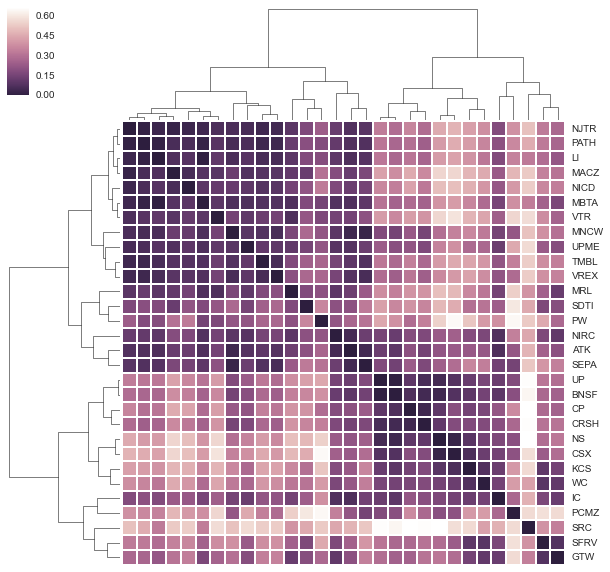

In [86]:
column_names = set(events_top.columns.values.tolist())
column_names.remove('Condition')
numerical = events_top
numerical = numerical[list(column_names)]
print len(numerical)
distance_matrix = squareform(pdist(numerical.values, metric='cosine'))
similarities = pd.DataFrame(distance_matrix, 
                            columns=list(numerical.index), 
                            index=list(numerical.index))
cg = sns.clustermap(similarities, method="complete", figsize=(10,10), 
                    xticklabels=False, metric='cosine', col_cluster=True,
                    cmap=sns.cubehelix_palette(reverse=True, light=1, as_cmap=True))

Here I show that I can cluster the trains in the northeast region together, showing that Hypothesis 1 has a basis. Trains in the same region have similar casualties.

SEPA - Philadelphia, 
MBTA - Boston, 
LI- Long Island, 
NJTR - New Jersey Transit
PATH - New Jersey - NYC 
ATK - Amtrak 
MNCW - Metronorth - NYC-> CT 
MACZ - Maryland -> DC 
NIRC (northern illinois) 
UPMC - Chicago and outlying areas

In [88]:
trans_state = {}
for train, group_data in cas.groupby('RR'):
    if len(group_data.St.unique()) > 3:
        trans_state[train]=group_data.St.unique()
trans = trans_state.keys()
cas['TRANS'] = cas.RR.apply(lambda row: 1 if row in trans else 0)

trans_state = {}
for train, group_data in cas.groupby('RR'):
    trans_state[train]= len(group_data.St.unique())
cas['STATES'] = cas.RR.apply(lambda rail: trans_state[rail])
cas = cas.drop(cas.columns[[0]],axis=1)

KeyError: 'RR'

In [ ]:
#conditions['STATES'] = conditions.index().apply(lambda rail: trans_state[rail])
for idx, row in conditions.iterrows():    
    conditions.ix[idx, 'STATES'] = trans_state[idx]    
    
for row, group_info in cas.groupby('RR'):
    conditions.ix[row,'AGE']=group_info.Age.mean()

In [ ]:
#trains.info()
X = conditions[['STATES']]
y = conditions['Sprain']

In [ ]:
model = sm.OLS(y, X)
results = model.fit()
print results.summary()
print "Confidence Intervals:", results.conf_int()
print "Parameters:", results.params
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 20
plt.scatter(X,y, c="slategray")
plt.plot(X,results.predict(X), c='seagreen', alpha=0.8)
plt.xlabel('Number of states RailRoad Services')
plt.ylabel('Number of Fatalities')
plt.title('Fatalities by Railroads in 2014')